# PHYS 3317 -- Time Evolution

Upload completed notebook to Blackboard at end of recitation section (or before next recitation if you do not complete it during the recitation period)

<font color="red"><em> Vineet Kamat </em></font>

<font color="blue"> This exercise is longer than the previous three.  I recommend first going through it with an eye for speed:  there are quite a few places where I give snippits of code.  You do not need to understand each line to use them -- most of the time you can get away with just copy and pasting, and making a few quick changes.  Once you have made it through, you can then start asking "why" certain notation works.</font>

<font color="blue">Given the length, we will work through this notebook as a group.  Feel free to follow along, or work on your own.</font>

In this notebook we will solve the time dependent Schrodinger equation.

$$i\hbar \partial_t \psi(x,t)=-\frac{\hbar^2}{2m} \partial_x^2 \psi(x,t)+V(x) \psi(x,t)$$

The first step is discretizing space, allowing us to replace the functions $\psi(x)$ with vectors $\vec\psi$,

$$i \partial_t\vec \psi(t)=H\vec\psi(t)$$

where we have decided to use units where $\hbar=1$. 

The next step is to make a finite difference in time.  There are two Canonical choices that you might have seen:

$$ \mbox{ Euler:}\quad i\frac{\vec\psi(t+\delta t)-\vec \psi(t)}{\delta t}= H\vec\psi(t)$$

$$\mbox{ Backwards Euler:}\quad i\frac{\vec\psi(t)-\vec \psi(t-\delta t)}{\delta t}= H\vec\psi(t)$$

The Euler method is known as an Explicit method, because it gives $\psi(t+\delta t)$ as an explicit function of $\psi(t)$:

$$\mbox{Euler:}\quad \vec\psi(t+\delta t)=\left(1-i H \delta t\right)\vec\psi(t)$$

where the expression in parentheses is just a matrix -- which you know how to construct

The Backwards Euler is known as an Implicit method, because it gives a set of linear equations which must be solved to increment time:

$$\mbox{Backward Euler:}\quad \left(1+i H \delta t\right)\vec\psi(t+\delta t)=\vec\psi(t)$$

In principle you can increment $\psi$ by inverting the matrix in parentheses.  In practice it is more efficient to solve this by using Gaussian Elimination.

Both the Euler and Backwards Euler methods suffer from numerical stability issues:  the normalization of the wavefunction is not conserved.  This can be solved by using a Semi-Implicit method:

$$ \mbox{ Semi-Implicit:}\quad i\frac{\vec\psi(t+\delta t)-\vec \psi(t)}{\delta t}= H\frac{\vec\psi(t+\delta t)+\vec\psi(t)}{2}$$

This can be rewritten as

$$\mbox{Semi-Implicit:}\quad \left(1+\frac{i H \delta t}{2}\right)\vec\psi(t+\delta t)= \left(1-\frac{i H \delta t}{2}\right)\vec\psi(t)$$

We will implement this semi-implicit technique -- last recitation we inverted the matrix by hand.  Here we will instead use row reduction to solve this matrix equation at each step.

## Implementation

We wish to solve

$$\left(1+\frac{i H \delta t}{2}\right)\vec\psi(t+\delta t)= \left(1-\frac{i H \delta t}{2}\right)\vec\psi(t)$$

First we need our Hamiltonian Matrix.  We will use the finite differences approach to produce a matrix which acts on discretized wavefunctions.  

We will store $H$ as a <em>Sparse</em> matrix.  If you do not remember what that means, you should look back at lab 2.

In [185]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [186]:
from __future__ import division  #get rid of integer division bug
from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
# if you get an error message, download showmat.py and put in directory with notebooks

First we make a function which generates the finite difference approximation to the second derivative.  You generated something like this in one of your homeworks.

In [187]:
# you don't need to do anything here -- just hit shift-enter
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))

To make this concrete lets generate examples

In [188]:
sm=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=False) #make an example

In [189]:
showmat(sm.todense()) # look at it

-8,4,,,,,,,
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
,,,,,,,4,-8


If that expression does not make sense, look at the "Finite Difference Approximation" notebook.

Here is the same thing, but with periodic boundary conditions

In [190]:
sm2=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=True) #make an example

In [191]:
showmat(sm2.todense()) # look at it

-8,4,,,,,,,4
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
4,,,,,,,4,-8


<font color=red>What is the difference between the case with and without periodic boundary conditions? </font> 

<font color=red>In the case of the first matrix, we don't influde the corner terms so we extrapolate the outside points using only the current point. The second matrix takes the value at the end points of the wavefunction which is good because it allows us to extrapolate on more than just the inside points by assuming the function is harmonic. </font>

Next we make a function which generates the finite difference approximation to the operator V(x).  This is a diagonal matrix:

$$
\left(
\begin{array}{ccccc}
V(x_1)&0&\cdots&&\cr
0&V(x_2)&0&0&\cdots\cr
0&0&V(x_3)&0&\cdots\cr
\vdots\cr
\vdots&&&&V(x_n)
\end{array}
\right)
\left(
\begin{array}{c}
\psi(x_1)\cr
\psi(x_2)\cr
\psi(x_3)\cr
\vdots\cr
\psi(x_n)
\end{array}
\right)=
\left(
\begin{array}{c}
V(x_1)\psi(x_1)\cr
V(x_2)\psi(x_2)\cr
V(x_3)\psi(x_3)\cr
\vdots\cr
V(x_n)\psi(x_n)
\end{array}\right)
$$


In [192]:
def PotentialMatrix(potential):
    """PotentialMatrix(potential)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potential -- the list of the potential values
    """

    ln=len(potential)
    return dia_matrix((potential,0),shape=(ln,ln))

Next, we want an example potential matrix -- lets use a harmonic oscillator

In [193]:
xlist=arange(-2,2,0.5)
xlist

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [194]:
vlist=xlist**2/2
vlist

array([2.   , 1.125, 0.5  , 0.125, 0.   , 0.125, 0.5  , 1.125])

In [195]:
pm=PotentialMatrix(vlist)
showmat(pm.todense())

2,,,,,,,
,1.12,,,,,,
,,0.5,,,,,
,,,0.12,,,,
,,,,,,,
,,,,,0.12,,
,,,,,,0.5,
,,,,,,,1.12


Finally we put it all together

In [196]:
# just hit shift-enter.  

def HamiltonianMatrix(potential,dx,periodic=True,hbar=1,mass=1):
    """HamiltonianMatrix(potential,dx,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potential -- a list of values for the potential
    dx -- the grid spacing
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    numpoints=len(potential)
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potential) #calculate potential energy operator
    return kin+pot

As another example, lets create a particle in a box Hamiltonian

In [197]:
xgrid=arange(0,pi,0.01*pi)
pot=zeros(len(xgrid))

hardwallham=HamiltonianMatrix(potential=pot,dx=0.01*pi,periodic=False)
showmat(hardwallham[:20,:20].todense()) # shows the upper 20x20 block of the matrix 

$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,,,
-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,,
,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,
,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,
,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,
,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,
,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,
,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,
,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,
,,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,
,,,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,


<font color=red>In the following cell create a matrix which corresponds to a Harmonic oscillator Hamiltonian.  Use units where $\omega=\hbar=m=1$, take the minimum of the oscillator to be at $x=\pi/2$, and use a grid with 100 points, with $0\leq x\leq \pi$.  Use showmat to view the upper $20\times20$ cells of the matrix</font>

In [198]:
xgrid=arange(0,pi,0.01*pi)
pot=((xgrid-pi/2)**2/2)
pot


array([1.23370055e+00, 1.18484601e+00, 1.13697843e+00, 1.09009781e+00,
       1.04420415e+00, 9.99297446e-01, 9.55377706e-01, 9.12444927e-01,
       8.70499108e-01, 8.29540250e-01, 7.89568352e-01, 7.50583415e-01,
       7.12585438e-01, 6.75574421e-01, 6.39550365e-01, 6.04513270e-01,
       5.70463134e-01, 5.37399960e-01, 5.05323745e-01, 4.74234491e-01,
       4.44132198e-01, 4.15016865e-01, 3.86888493e-01, 3.59747080e-01,
       3.33592629e-01, 3.08425138e-01, 2.84244607e-01, 2.61051036e-01,
       2.38844427e-01, 2.17624777e-01, 1.97392088e-01, 1.78146359e-01,
       1.59887591e-01, 1.42615784e-01, 1.26330936e-01, 1.11033050e-01,
       9.67221231e-02, 8.33981572e-02, 7.10611517e-02, 5.97111066e-02,
       4.93480220e-02, 3.99718978e-02, 3.15827341e-02, 2.41805308e-02,
       1.77652879e-02, 1.23370055e-02, 7.89568352e-03, 4.44132198e-03,
       1.97392088e-03, 4.93480220e-04, 2.46519033e-32, 4.93480220e-04,
       1.97392088e-03, 4.44132198e-03, 7.89568352e-03, 1.23370055e-02,
      

In [199]:

hardwallham_2=HamiltonianMatrix(potential=pot,dx=0.01*pi,periodic=False)
showmat(hardwallham_2[:20,:20].todense()) # shows the upper 20x20 block of the matrix 

$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,,,
-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,,
,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,,
,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,,
,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,,
,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,,
,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,,
,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,,
,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,,
,,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,,
,,,,,,,,,-506.61,$1.0\cdot10^{3}$,-506.61,,,,,,,,


Lets also create a wavepacket to start with

In [200]:
def wavepacket(xgrid,x,k,width):
    return exp(1.j*k*xgrid-(xgrid-x)**2/(2*width**2))

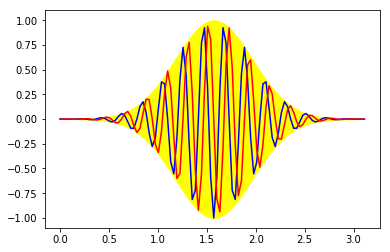

In [201]:
wavefunction=wavepacket(xgrid,x=pi/2,k=30,width=pi/8)
# plot it
fill_between(xgrid,abs(wavefunction),-abs(wavefunction),alpha=1,color="yellow")
plot(xgrid,real(wavefunction),color="blue")
plot(xgrid,imag(wavefunction),color="red")

## Visualization

We now load an animation package

In [202]:
%gui tk  
# setup the ipython notebook so that it can generate graphics windows using the tk backend

In [203]:
import TDSEviewer3  # load the module that has the Schrodinger equation viewer
from TDSEviewer3 import *  # loads those functions into the main namespace

Run the following cell to create a viewer window.  A window should pop up.  The blue line represents the real part of the wavefunction, the green the imaginary

In [204]:
viewer=TDSEviewer(wavefunction=wavefunction,grid=xgrid)  # open up a viewer window

The following cell resets the viewer window to its original state.  Run it whenever you want to reset things

In [205]:
viewer.wavefunction=wavefunction  
viewer.updatelines()

Lets now make a little program which animates a changing wavefunction.  This is just a made-up dynamics to illustrate how the program works

In [206]:
# initialize
t=0.
dt1=0.2
viewer.ylim(-1.1,1.1)
viewer.force_redraw()

# loop over timesteps
while t<2.:
    viewer.wavefunction=cos(xgrid+t)+1j*sin(xgrid+t)
    viewer.updatelines()
    viewer.set_title(t)
    t=t+dt1
viewer.force_redraw()

<font color=red>Copy the code from the previous line, and modify it so that the running waves move in the other direction.</font>

In [207]:
# initialize
t=0.
dt1=0.2
viewer.ylim(-1.1,1.1)
viewer.force_redraw()

# loop over timesteps
while t<2.:
    viewer.wavefunction=cos(xgrid-t)+1j*sin(xgrid-t)
    viewer.updatelines()
    viewer.set_title(t)
    t=t+dt1
viewer.force_redraw()

We then close the window

In [208]:
viewer.close()

Our next step is to animate evolution coming from 

$$\left(1+iH \delta t/2\right) \psi(t+\delta t)=\left(1-iH\delta t/2\right)\psi(t)$$

In [209]:
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse

In [210]:
# Hit shift-enter to generate the functions needed to evolve the wavefunction
# This uses a very efficient linear-algebra algorithm known as LU decomposition

dt=0.001  # set time step

dx=0.01*pi  # set x step
xgrid=arange(0,pi,dx)  # generate grid
pot=zeros(len(xgrid))  # generate potential
hardwallham=HamiltonianMatrix(potential=pot,dx=dx,periodic=False) #make Hamiltonian

csrham=csc_matrix(hardwallham)                              # convert to more efficient format
hamsize=hardwallham.shape[0]                                # figure out how big the matrix is
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right

With these operators we can do time evolution as follows:

In [211]:
viewer=TDSEviewer(wavefunction=wavefunction,grid=xgrid)  # open up a viewer window
viewer.reset()

Make window bigger (you can also do this by dragging)

In [212]:
viewer.set_geometry(1000,500)

The slowest part of the algorithm is actually plotting the curve, so here is a trick which plots only every 10th interation 

In [213]:
# initialize
t=0.
viewer.ylim(-1,1)
viewer.wavefunction=wavefunction
viewer.xlim(0,pi)

counter=0
# loop over timesteps
while t<1.:
    viewer.wavefunction=inverseLHS(RHSOperator.dot(viewer.wavefunction))
    if counter%10==0:
        viewer.updatelines()
        viewer.set_title(t)
    t=t+dt
    counter=counter+1

viewer.force_redraw()

You can access the data directly, as shown by the following cell.  

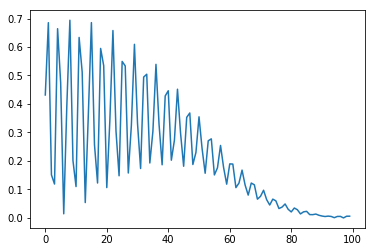

In [214]:
plot(abs(viewer.wavefunction)**2)

Close the viewer

In [215]:
viewer.close()

<h2> Some Tricks </h2>

Suppose you wanted to store every wavefunction as it is generated, you might do something like

In [216]:
viewer=TDSEviewer()

In [217]:
# initialize
t=0.

dt=0.001 # set time step

dx=0.01*pi
xgrid=arange(0,pi,dx)
pot=zeros(len(xgrid))
hardwallham=HamiltonianMatrix(potential=pot,dx=dx,periodic=False) #make Hamiltonian

csrham=csc_matrix(hardwallham)                              # convert to more efficient format
hamsize=hardwallham.shape[0]
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right


viewer.wavefunction=wavepacket(xgrid,x=pi/2,k=30,width=pi/8)
viewer.grid=xgrid
viewer.xlim(0,pi)
viewer.ylim(-2,2)
viewer.dx=dx
viewer.force_redraw()


timeseries=[] # list which will contain the wavefunctions

counter=0
# loop over timesteps
while t<1.5:
    viewer.wavefunction=inverseLHS(RHSOperator.dot(viewer.wavefunction))
    #viewer.rescale()
    timeseries.append([t,viewer.wavefunction])
    if counter%20==0:
        viewer.set_title(t)
        viewer.updatelines()
    t=t+dt
    counter=counter+1
    

In [218]:
viewer.force_redraw()

In [219]:
viewer.close()

If we just want the wavefunctions (and not the times) we can unpack the data using a "list comprehension"

In [220]:
wfseries=array([wf for time,wf in timeseries])

This can then be shown in a density plot

Text(0,0.5,'t')

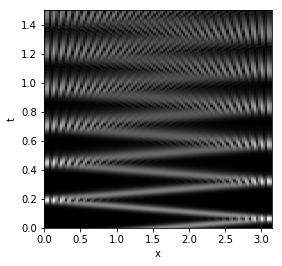

In [221]:
imshow(abs(wfseries),aspect=2,origin="lower",extent=(0,pi,0,t))
xlabel("x")
ylabel("t")

<font color=red><b> Problem:</b> Give a qualitative description of this behavior, and explain the main features.</font>

<em> The particle is bouncing from wall to wall </em>

<font color=red><b> Problem:</b> Make a plot like this with periodic boundary conditions instead of hard wall.</font>

In [222]:
viewer=TDSEviewer()

# initialize
t=0.

dt=0.001 # set time step

dx=0.01*pi
xgrid=arange(0,pi,dx)
pot=zeros(len(xgrid))
hardwallham=HamiltonianMatrix(potential=pot,dx=dx,periodic=True) #make Hamiltonian

csrham=csc_matrix(hardwallham)                              # convert to more efficient format
hamsize=hardwallham.shape[0]
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right


viewer.wavefunction=wavepacket(xgrid,x=pi/2,k=30,width=pi/8)
viewer.grid=xgrid
viewer.xlim(0,pi)
viewer.ylim(-2,2)
viewer.dx=dx
viewer.force_redraw()

timeseries=[] # list which will contain the wavefunctions

counter=0
# loop over timesteps
while t<1.5:
    viewer.wavefunction=inverseLHS(RHSOperator.dot(viewer.wavefunction))
    #viewer.rescale()
    timeseries.append([t,viewer.wavefunction])
    if counter%20==0:
        viewer.set_title(t)
        viewer.updatelines()
    t=t+dt
    counter=counter+1

viewer.force_redraw()

<h2> Encapsulation </h2>

One way to work with a notebook is to simply copy and paste a cell which is your "program" -- making changes as necessary (for example, changing the potential).  Another strategy is to encapsulate the simulation in either a function, or a more sophisticated object.  Once you have figured out what you want to calculate, you will find encapsulation is more efficient.  During the exploration phase, you may find the copying and pasting to be more efficient.  Here is one encapsulation strategy for the part of our program which generates the evolution matrices.  Typically we would also encapsulate the loop that does time evolution, but this is profound enough that one example is probably enough for now.  Fill in the missing code.

In [223]:
# Fill in the missing code

class tdse:
    """ tdse generates the machinery for evolving a wavefunction.  Call it with
    tdse(dt,dx,pot,periodic): dt is the timestep, dx is the spatial discretization,
    pot is a list of values of the potential on the grid.  periodic is True or False,
    depending on if you want periodic boundary conditions"""
    
    def __init__(self,dt,dx,pot,periodic=False):
        self.dt=dt
        self.dx=dx
        self.pot=pot
        self.periodic=periodic
        self.ham=HamiltonianMatrix(potential=pot,dx=dx,periodic=periodic)
        
        csrham=csc_matrix(self.ham)                              # convert to more efficient format
        hamsize=(self.ham).shape[0]
        LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
        inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
        RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right
        
    def evolve(self,wavefunction):
        return self.inverseLHS(self.RHSOperator.dot(wavefunction))

<h2> Application1 -- the harmonic oscillator </h2>

In this section we study the evolution of a wavepacket for a harmonic oscillator 

In [173]:
dx=0.01
xgrid=arange(-10,10,dx)
omega=2.*pi
def harmpot(x):
    return 0.5*omega**2*x**2

harmdat=harmpot(xgrid)  # calculate the potential

viewer=TDSEviewer(wavefunction=wavepacket(xgrid,x=-2,k=0.,width=0.5),grid=xgrid,potential=harmdat)

Now lets generate the functions you need for time evolution

In [174]:
ho=tdse(dt=0.001,dx=dx,pot=harmdat)


# That one line replaces all of this:
#  dt=0.001
#  harmham=HamiltonianMatrix(potential=harmdat,dx=dx,periodic=False) # make Hamiltonian
#  csrham=csc_matrix(harmham)                              # convert to more efficient format
#  hamsize=harmham.shape[0]
#  LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
#  inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
#  RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right


Animate the evolution

In [175]:
viewer=TDSEviewer()
viewer.wavefunction=wavepacket(xgrid,x=pi/2,k=30,width=pi/8)
viewer.grid=xgrid
viewer.xlim(0,pi)
viewer.ylim(-2,2)
viewer.dx=dx
viewer.force_redraw()

timeseries=[] # list which will contain the wavefunctions

counter=0
t=0.

# loop over timesteps
while t<4:
    if counter%20==0:
        viewer.updatelines()
        viewer.set_title(t)
    timeseries.append([t,viewer.wavefunction])
    viewer.wavefunction=ho.evolve(viewer.wavefunction)
    t=t+dt
    counter=counter+1

AttributeError: tdse instance has no attribute 'inverseLHS'

You should have seen a wavepacket bouncing back and forth in the harmonic potential.  

<h3> Studying the data </h3>

The first thing we now want to do is take a look at a plot of the probability density as a function of position and time

In [ ]:
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=4,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator")
ylabel("t")
xlabel("x")
colorbar()
#uncomment the next line to save the figure
#savefig("pdens.png")

The array wfseries is a sequence of 4001 wavefunctions at sequential timesteps.  Each wavefunction is a vector of 2000 complex numbers

In [ ]:
wfseries.shape

We can readily verify that the probability density is conserved

In [ ]:
norms=(abs(wfseries)**2).sum(1)
plot(norms)
xlabel("time slice")
ylabel("sum of squares of elements")

Next lets make a plot of $\langle x\rangle$ as a function of time.  We will call this time series "posseries"

In [ ]:
posseries= dot(abs(wfseries)**2,xgrid)/norms

In [ ]:
times=array([time for time,wf in timeseries])

In [ ]:
plot(times,posseries)
xlabel("time")
ylabel("position")
title("harmonic oscillator with Period 1")

<strong> Exercise:</strong>  Repeat this numerical experiment, but this time start with a wave-function which is a superposition of two (initially stationary) wave-packets, one at x=-2 and one at x=2.  Make a plot of the probability density as a function of space and time.  Properly label the axes.  

In [176]:
dx=0.01
xgrid=arange(-10,10,dx)
omega=2.*pi
def harmpot(x):
    return 0.5*omega**2*x**2

harmdat=harmpot(xgrid)  # calculate the potential

wavep1 = wavepacket(xgrid,-2,k=0,width=.05)
wavep2 = wavepacket(xgrid,2,k=0,width=.05)


viewer=TDSEviewer(wavefunction=(wavep1+wavep2),grid=xgrid,potential=harmdat)


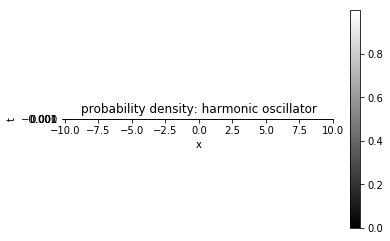

In [177]:
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=4,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator")
ylabel("t")
xlabel("x")
colorbar()

Text(0,0.5,'sum of squares of elements')

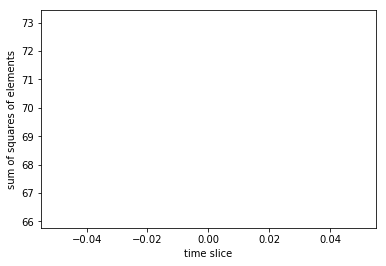

In [178]:
norms=(abs(wfseries)**2).sum(1)
plot(norms)
xlabel("time slice")
ylabel("sum of squares of elements")

<strong> Exercise:</strong>  Repeat for a packet which starts off stationary at x=0.  Make a plot of the probability density as a function of space and time.  Properly label the axes.  

In [179]:
dx=0.01
xgrid=arange(-10,10,dx)
omega=2.*pi
def harmpot(x):
    return 0.5*omega**2*x**2

harmdat=harmpot(xgrid)  # calculate the potential

wavep1 = wavepacket(xgrid,0,k=0,width=.05)


viewer=TDSEviewer(wavefunction=(wavep1),grid=xgrid,potential=harmdat)

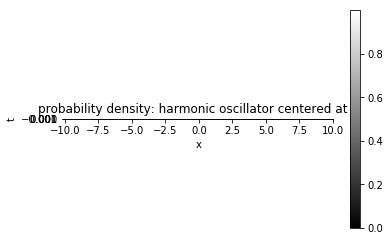

In [180]:
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=4,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator centered at 0")
ylabel("t")
xlabel("x")
colorbar()

Text(0.5,1,'harmonic oscillator centered at 0')

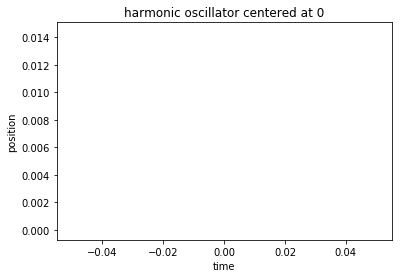

In [181]:
posseries= abs(wfseries)**2/norms
plot(times,posseries)
xlabel("time")
ylabel("position")
title("harmonic oscillator centered at 0")

<strong> Exercise:</strong>  Repeat for a packet which starts off stationary at x=0, and has width of width=1 instead of width=1/2.  Make a plot of $\langle x^2 \rangle$ vs time.  Properly label the axes.  

In [182]:
dx=0.01
xgrid=arange(-10,10,dx)
omega=2.*pi
def harmpot(x):
    return 0.5*omega**2*x**2

harmdat=harmpot(xgrid)  # calculate the potential

wavep1 = wavepacket(xgrid,0,k=0,width=.05)


viewer=TDSEviewer(wavefunction=(wavep1),grid=xgrid,potential=harmdat)

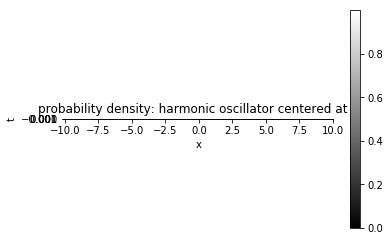

In [183]:
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=4,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator centered at 0")
ylabel("t")
xlabel("x")
colorbar()

Text(0.5,1,'harmonic oscillator centered at 0')

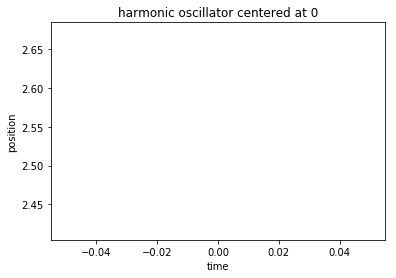

In [184]:
posseries= dot(abs(wfseries)**2,xgrid**2)/norms
plot(times,posseries)
xlabel("time")
ylabel("position")
title("harmonic oscillator centered at 0")

<strong> Exercise:</strong>  How does the period of oscillation of $\langle x^2\rangle$ in the last problem compare to the oscillation  period of $\langle x\rangle$ in the original simulation.

My code doesn't seem to output a file, but the period of oscillation, in my estimation, should stay the same